In [1]:
# -------------------------------------------------------------------
# Copyright (C) 2020 Harbin Institute of Technology, China
# Author: Xudong Lv (15B901019@hit.edu.cn)
# Released under Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# http://creativecommons.org/licenses/by-nc-sa/4.0/
# -------------------------------------------------------------------

import math
import os
import random
import time

# import apex
import mathutils
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torch.nn as nn

import torchvision
from torchvision import transforms
from torchvision.transforms import functional as tvtf

from sacred import Experiment
from sacred.utils import apply_backspaces_and_linefeeds

from DatasetLidarCamera_Ver8_5 import DatasetLidarCameraKittiOdometry
from losses_Ver8_5 import DistancePoints3D, GeometricLoss, L1Loss, ProposedLoss, CombinedLoss


from quaternion_distances import quaternion_distance

from tensorboardX import SummaryWriter
from utils import (mat2xyzrpy, merge_inputs, overlay_imgs, quat2mat,
                   quaternion_from_matrix, rotate_back, rotate_forward,
                   tvector2mat)

from LCCNet_COTR_moon_Ver8_5 import LCCNet
from COTR.inference.sparse_engine_Ver3 import SparseEngine
import warnings
warnings.filterwarnings('ignore')

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

ex = Experiment("LCCNet" , interactive = True)
ex.captured_out_filter = apply_backspaces_and_linefeeds
from sacred import SETTINGS 
SETTINGS.CONFIG.READ_ONLY_CONFIG = False

np.seterr(invalid='ignore')

# import multiprocessing as mp
# mp.set_start_method('spawn')

cannot use vispy, setting triangulate_corr as None


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
####### dataset path root ############ 
"""
root_dir = "/mnt/data/kitti_odometry"
calib_path ="data_odometry_calib"
image_path ="data_odometry_color"
velodyne_path = "data_odometry_velodyne"
imagegray_path = "data_odometry_gray"
poses_path = "data_odometry_poses"
"""
#######################################
# noinspection PyUnusedLocal
@ex.config
def config():
    checkpoints = './checkpoints/'
    dataset = 'kitti/odom' # 'kitti/raw'
    data_folder = "/mnt/data/kitti_odometry"
    use_reflectance = False
    val_sequence = 6
    epochs = 200
    BASE_LEARNING_RATE = 1e-4 # 1e-4
    loss = 'combined'
    max_t = 0.2 # 1.5, 1.0,  0.5,  0.2,  0.1
    max_r = 7.5 # 20.0, 10.0, 5.0,  2.0,  1.0
    batch_size = 1  # 120
    num_worker = 10
    network = 'Res_f1'
    optimizer = 'adam'
    resume = True
#     weights = '/root/work/LCCNet_Moon/checkpoints/kitti/odom/val_seq_06/models/checkpoint_r7.50_t0.20_e125_0.127.tar'
    weights = None
    rescale_rot = 1
    rescale_transl = 1
    precision = "O0"
    norm = 'bn'
    dropout = 0.0
    max_depth = 80.
    weight_point_cloud = 0.3
    log_frequency = 1000
    print_frequency = 50
    starting_epoch = 125

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1, 2, 3'

EPOCH = 1
def _init_fn(worker_id, seed):
    seed = seed + worker_id + EPOCH*100
    print(f"Init worker {worker_id} with seed {seed}")
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def get_2D_lidar_projection(pcl, cam_intrinsic):
    pcl_xyz = cam_intrinsic @ pcl.T
    pcl_xyz = pcl_xyz.T
    pcl_z = pcl_xyz[:, 2]
    pcl_xyz = pcl_xyz / (pcl_xyz[:, 2, None] + 1e-10)
    pcl_uv = pcl_xyz[:, :2]

    return pcl_uv, pcl_z


def lidar_project_depth(pc_rotated, cam_calib, img_shape):
    pc_rotated = pc_rotated[:3, :].detach().cpu().numpy()
    cam_intrinsic = cam_calib.numpy()
    pcl_uv, pcl_z = get_2D_lidar_projection(pc_rotated.T, cam_intrinsic)
    mask = (pcl_uv[:, 0] > 0) & (pcl_uv[:, 0] < img_shape[1]) & (pcl_uv[:, 1] > 0) & (
            pcl_uv[:, 1] < img_shape[0]) & (pcl_z > 0)
    pcl_uv = pcl_uv[mask]
    pcl_z = pcl_z[mask]
    pcl_uv = pcl_uv.astype(np.uint32)
    pcl_z = pcl_z.reshape(-1, 1)
    depth_img = np.zeros((img_shape[0], img_shape[1], 1))
    depth_img[pcl_uv[:, 1], pcl_uv[:, 0]] = pcl_z
    depth_img = torch.from_numpy(depth_img.astype(np.float32))
    depth_img = depth_img.cuda()
    depth_img = depth_img.permute(2, 0, 1)

    return depth_img, pcl_uv

In [3]:
# CNN training
@ex.capture
def train(model, optimizer, rgb_input, dense_depth_input, corrs , target_transl, target_rot, loss_fn, point_clouds, loss):
    model.train()

    optimizer.zero_grad()
    
#     ####### display input signal #########        
#     plt.figure(figsize=(10, 10))
# #         plt.imshow(cv2.cvtColor(torchvision.utils.make_grid(rgb_input).cpu().numpy() , cv2.COLOR_BGR2RGB))
#     plt.imshow(torchvision.utils.make_grid(rgb_input).cpu().numpy())
#     plt.title("RGB_input", fontsize=22)
#     plt.axis('off')

    
    queries     = corrs[:, :, :2]
    corr_target = corrs[:, :, 2:]

    # Run model
    #transl_err, rot_err = model(rgb_img, refl_img)
    transl_err, rot_err , corr_pred , cycle , mask = model(rgb_input, dense_depth_input, queries , corr_target)
    """
    print("transl_err==========",transl_err)
    print("rot_err=============",rot_err)
    print("point_clouds=============",point_clouds)
    print("target_transl=============",target_transl)
    print("target_rot=============",target_rot)
    """
    
    if loss == 'points_distance' or loss == 'combined':
        losses = loss_fn(point_clouds, target_transl, target_rot, transl_err, rot_err , corr_target , corr_pred , queries ,cycle, mask)
    else:
        losses = loss_fn(target_transl, target_rot, transl_err, rot_err)
    
    #print("losses=============",losses)
    if loss == 'points_distance' or loss == 'combined':
        losses['total_loss'].backward()
    else: 
        losses.backward()
    
    optimizer.step()

    return losses, rot_err, transl_err

In [4]:
# CNN test
@ex.capture
def val(model, rgb_input, dense_depth_input ,corrs ,target_transl, target_rot, loss_fn, point_clouds, loss):
    model.eval()

    queries     = corrs[:, :, :2]
    corr_target = corrs[:, :, 2:]

    # Run model
    with torch.no_grad():
        #transl_err, rot_err = model(rgb_img, refl_img)
        transl_err, rot_err,corr_pred ,cycle , mask = model(rgb_input,dense_depth_input, queries ,corr_target)

    if loss == 'points_distance' or loss == 'combined':
        losses = loss_fn(point_clouds, target_transl, target_rot, transl_err, rot_err, corr_target , corr_pred ,queries ,cycle, mask)
    else:
        losses = loss_fn(target_transl, target_rot, transl_err, rot_err)

    # if loss != 'points_distance':
    #     total_loss = loss_fn(target_transl, target_rot, transl_err, rot_err)
    # else:
    #     total_loss = loss_fn(point_clouds, target_transl, target_rot, transl_err, rot_err)

    total_trasl_error = torch.tensor(0.0).cuda()
    target_transl = torch.tensor(target_transl).cuda()
    total_rot_error = quaternion_distance(target_rot, rot_err, target_rot.device)
    total_rot_error = total_rot_error * 180. / math.pi
    for j in range(rgb_input.shape[0]):
        total_trasl_error += torch.norm(target_transl[j] - transl_err[j]) * 100.

    # # output image: The overlay image of the input rgb image and the projected lidar pointcloud depth image
    # cam_intrinsic = camera_model[0]
    # rotated_point_cloud =
    # R_predicted = quat2mat(R_predicted[0])
    # T_predicted = tvector2mat(T_predicted[0])
    # RT_predicted = torch.mm(T_predicted, R_predicted)
    # rotated_point_cloud = rotate_forward(rotated_point_cloud, RT_predicted)

    return losses, total_trasl_error.item(), total_rot_error.sum().item(), rot_err, transl_err
#     return losses, total_trasl_error.item(), rot_err, transl_err

In [5]:
#@ex.automain
@ex.main
def main(_config, _run, seed):
    global EPOCH
    print('Loss Function Choice: {}'.format(_config['loss']))

    if _config['val_sequence'] is None:
        raise TypeError('val_sequences cannot be None')
    else:
        _config['val_sequence'] = f"{_config['val_sequence']:02d}"
        print("Val Sequence: ", _config['val_sequence'])
        dataset_class = DatasetLidarCameraKittiOdometry
        
    img_shape = (384, 1280) # 네트워크의 입력 규모
    input_size = (256, 512)
    _config["checkpoints"] = os.path.join(_config["checkpoints"], _config['dataset'])

    dataset_train = dataset_class(_config['data_folder'], max_r=_config['max_r'], max_t=_config['max_t'],
                                  split='train', use_reflectance=_config['use_reflectance'],
                                  val_sequence=_config['val_sequence'])
    dataset_val = dataset_class(_config['data_folder'], max_r=_config['max_r'], max_t=_config['max_t'],
                                split='val', use_reflectance=_config['use_reflectance'],
                                val_sequence=_config['val_sequence'])
        
    train_dataset_size = len(dataset_train)
    val_dataset_size = len(dataset_val)
    print('Number of the train dataset: {}'.format(train_dataset_size))
    print('Number of the val dataset: {}'.format(val_dataset_size))
    
#     ##### verify - monitoring dataset train ##########
#     rgb = dataset_train[129]['rgb']
#     depth_img =  dataset_train[129]['depth_img']
#     depth_gt_img = dataset_train[129]['depth_gt']


#     plt.figure(figsize=(10, 10))
#     plt.subplot(311)
#     plt.imshow(rgb)
#     plt.title("After RGB_resize", fontsize=22)
#     plt.axis('off')

#     plt.subplot(312)
#     plt.imshow(depth_img, cmap='magma')
#     plt.title("After miscalibrated_Lidar_resize", fontsize=22)
#     plt.axis('off');  
    
#     plt.subplot(313)
#     plt.imshow(depth_gt_img, cmap='magma')
#     plt.title("After Lidar_gt_resize", fontsize=22)
#     plt.axis('off'); 
    
    ####### searching pre-trained model parameter dir ##############
    model_savepath = os.path.join(_config['checkpoints'], 'val_seq_' + _config['val_sequence'], 'models')
    if not os.path.exists(model_savepath):
        os.makedirs(model_savepath)
    log_savepath = os.path.join(_config['checkpoints'], 'val_seq_' + _config['val_sequence'], 'log')
    print ('log_savepath :' , log_savepath)
    if not os.path.exists(log_savepath):
        os.makedirs(log_savepath)
    
    train_writer = SummaryWriter(os.path.join(log_savepath, 'train'))
    val_writer = SummaryWriter(os.path.join(log_savepath, 'val'))

    np.random.seed(seed)
    torch.random.manual_seed(seed)

    def init_fn(x): return _init_fn(x, seed)
    
    # Training and validation set creation
    num_worker = _config['num_worker']
    batch_size = _config['batch_size']
    print("batch_size=" , batch_size)
    TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train,
                                                 shuffle=True,
                                                 batch_size=batch_size,
                                                 num_workers=num_worker,
                                                 worker_init_fn=init_fn,
                                                 collate_fn=merge_inputs,
                                                 drop_last=False,
                                                 pin_memory=True)

    ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val,
                                                shuffle=False,
                                                batch_size=batch_size,
                                                num_workers=num_worker,
                                                worker_init_fn=init_fn,
                                                collate_fn=merge_inputs,
                                                drop_last=False,
                                                pin_memory=True)

    print(len(TrainImgLoader))
    print(len(ValImgLoader))
    
    # loss function choice
    if _config['loss'] == 'simple':
        loss_fn = ProposedLoss(_config['rescale_transl'], _config['rescale_rot'])
    elif _config['loss'] == 'geometric':
        loss_fn = GeometricLoss()
        loss_fn = loss_fn.cuda()
    elif _config['loss'] == 'points_distance':
        loss_fn = DistancePoints3D()
    elif _config['loss'] == 'L1':
        loss_fn = L1Loss(_config['rescale_transl'], _config['rescale_rot'])
    elif _config['loss'] == 'combined':
        loss_fn = CombinedLoss(_config['rescale_transl'], _config['rescale_rot'], _config['weight_point_cloud'])
    else:
        raise ValueError("Unknown Loss Function")
    
    # network choice and settings
    if _config['network'].startswith('Res'):
        feat = 1
        md = 4
        split = _config['network'].split('_')
        for item in split[1:]:
            if item.startswith('f'):
                feat = int(item[-1])
            elif item.startswith('md'):
                md = int(item[2:])
        assert 0 < feat < 7, "Feature Number from PWC have to be between 1 and 6"
        assert 0 < md, "md must be positive"   
        ### netwrok define ####
        model = LCCNet(input_size, use_feat_from=feat, md=md,
                         use_reflectance=_config['use_reflectance'], dropout=_config['dropout'],
                         Action_Func='leakyrelu', attention=False, res_num=50)
    else:
        raise TypeError("Network unknown")
    if _config['weights'] is not None:
        print(f"Loading weights from {_config['weights']}")
        checkpoint = torch.load(_config['weights'], map_location='cpu')
        print('-------checkpoint-keys-------',checkpoint.keys() )
        saved_state_dict = checkpoint['state_dict']
        model.load_state_dict(saved_state_dict)

    ########### parallel gpu loding ###########
    model = nn.DataParallel(model)
    model = model.cuda()

    print('Number of model parameters: {}'.format(sum([p.data.nelement() for p in model.parameters()])))

    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
    
    ############ optimizer setting ##############
    if _config['loss'] == 'geometric':
        parameters += list(loss_fn.parameters())
    if _config['optimizer'] == 'adam':
        optimizer = optim.Adam(parameters, lr=_config['BASE_LEARNING_RATE'], weight_decay=5e-6)
        # Probably this scheduler is not used
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50, 70], gamma=0.5)
#         scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50, 70], gamma=0.3)
    else:
        optimizer = optim.SGD(parameters, lr=_config['BASE_LEARNING_RATE'], momentum=0.9,
                              weight_decay=5e-6, nesterov=True)
    
    ########## training resume setting ###############
    starting_epoch = _config['starting_epoch']
    if _config['weights'] is not None and _config['resume']:
        checkpoint = torch.load(_config['weights'], map_location='cpu')
        opt_state_dict = checkpoint['optimizer']
        optimizer.load_state_dict(opt_state_dict)
        if starting_epoch != 0:
            starting_epoch = checkpoint['epoch']

    ######### training epoch ########################3
    start_full_time = time.time()
    BEST_VAL_LOSS = 10000.
    old_save_filename = None

    train_iter = 0
    val_iter = 0
    real_shape = [376 , 1241 ,3]
    
    for epoch in range(starting_epoch, _config['epochs'] + 1):
        EPOCH = epoch
        print('This is %d-th epoch' % epoch)
        epoch_start_time = time.time()
        
        total_train_loss = 0
        local_loss = 0.
        total_val_loss = 0.
        total_val_t = 0.
        total_val_r = 0.
        
        if _config['optimizer'] != 'adam':
            _run.log_scalar("LR", _config['BASE_LEARNING_RATE'] *
                            math.exp((1 - epoch) * 4e-2), epoch)
            for param_group in optimizer.param_groups:
                param_group['lr'] = _config['BASE_LEARNING_RATE'] * \
                                    math.exp((1 - epoch) * 4e-2)
        else:
            #scheduler.step(epoch%100)
            _run.log_scalar("LR", scheduler.get_lr()[0])
    
    ########### traing batch #############################
        time_for_50ep = time.time()
 
        for batch_idx, sample in enumerate(TrainImgLoader):
            print(f'batch {batch_idx+1}/{len(TrainImgLoader)}', end='\r')
            start_time = time.time()
#             lidar_input = []
            rgb_input = []
            lidar_gt_input = []
#             query_input = []
#             query_gt_input = []
            corrs_input =[]
            dense_depth_img_input =[]
            pc_rotated_input = []

            # gt pose
            sample['tr_error'] = sample['tr_error'].cuda()
            sample['rot_error'] = sample['rot_error'].cuda()
            
            start_preprocess = time.time()
            for idx in range(len(sample['rgb'])):
#                 rgb = sample['rgb'][idx].cuda()
                rgb = sample['rgb'][idx]
#                 depth_img = sample['depth_img'][idx].cuda()
                lidar_gt = sample['lidar_gt'][idx].cuda()
#                 query = sample['gt_uv'][idx].cuda()
#                 query_gt = sample['uv'][idx].cuda()
                corrs = sample['corrs'][idx].cuda()
                dense_depth_img = sample['dense_depth_img'][idx].cuda()
                pc_rotated = sample['pc_rotated'][idx].cuda()
                
        
                # batch stack 
                rgb_input.append(rgb)
#                 lidar_input.append(depth_img)
                lidar_gt_input.append(lidar_gt)
#                 query_input.append(query)
#                 query_gt_input.append(query_gt)
                corrs_input.append(corrs)
                dense_depth_img_input.append(dense_depth_img)
                pc_rotated_input.append(pc_rotated)
            
            rgb_input = torch.stack(rgb_input)
#             lidar_input = torch.stack(lidar_input)
#             query_input = torch.stack(query_input)
#             query_gt_input = torch.stack(query_gt_input)
            corrs_input = torch.stack(corrs_input)
            dense_depth_img_input = torch.stack(dense_depth_img_input)
            
            rgb_input = rgb_input.permute(0,2,3,1)
#             sbs_img = rgb_input.clone()
#             rgb_show = rgb_show.permute(0,2,3,1)
#             rgb_show = sbs_img[: , : , :, :640]
#             lidar_show = sbs_img[: , : , :, 640:]
#             print ('rgb_show shape' , rgb_show.shape)
#             lidar_input = lidar_input.permute(0,3,1,2)
            dense_depth_img_input = dense_depth_img_input.permute(0,2,3,1)
            
            end_preprocess = time.time()
#             print("rgb_input===========",rgb_input.shape)
#             print("lidar_input===========",lidar_input.shape)
#             print("query_input===========",query_input.shape)
#             print("query_gt_input===========",query_gt_input.shape)
#             print("corrs_input===========",corrs_input.shape)
#             print("dense_depth_img_input===========",dense_depth_img_input.shape)
            
            loss, R_predicted,  T_predicted = train(model, optimizer, rgb_input, dense_depth_img_input , corrs_input ,
                                      sample['tr_error'], sample['rot_error'],
                                      loss_fn, sample['point_cloud'], _config['loss'])
        
            if _config['loss'] == 'points_distance' or _config['loss'] == 'combined':
                local_loss += loss['total_loss'].item()
            else :
                local_loss += loss.item()
            
            train_local_loss = local_loss/50

            if batch_idx % _config['log_frequency'] == 0:
                show_idx = 0
                # output image: The overlay image of the input rgb image
                # and the projected lidar pointcloud depth image
                rotated_point_cloud = pc_rotated_input[show_idx]
                R_predicted = quat2mat(R_predicted[show_idx])
                T_predicted = tvector2mat(T_predicted[show_idx])
                RT_predicted = torch.mm(T_predicted, R_predicted)
                rotated_point_cloud = rotate_forward(rotated_point_cloud, RT_predicted)

#                 depth_pred, uv = lidar_project_depth(rotated_point_cloud,
#                                                     sample['calib'][show_idx],
#                                                     real_shape_input[show_idx]) # or image_shape
                depth_pred, uv = lidar_project_depth(rotated_point_cloud,
                                                    sample['calib'][show_idx],
                                                    real_shape) # or image_shape
                depth_pred /= _config['max_depth']
#                 depth_pred = F.pad(depth_pred, shape_pad_input[show_idx])
#                 print ('depth_pred shape' , depth_pred.shape)
#                 print ('rgb_show shape' , rgb_show[show_idx].shape)
#                 print ('lidar_show shape' , lidar_show[show_idx].shape)
#                 print ('lidar_gt show shape' , lidar_gt_input[show_idx].shape)
                depth_pred = depth_pred.permute(1,2,0)
                depth_pred_np = depth_pred.cpu().numpy()
                depth_pred_np_resized = cv2.resize(depth_pred_np, (640,192), interpolation=cv2.INTER_LINEAR)
                depth_pred_np_resized_tensor = transforms.ToTensor()(depth_pred_np_resized)
#                 depth_pred_np_resized_tensor = depth_pred_np_resized_tensor.permute(1,2,0)
#                 print ('depth_pred_np_resized_tensor shape' , depth_pred_np_resized_tensor.shape)

#                 pred_show = overlay_imgs(rgb_show[show_idx], depth_pred_np_resized_tensor.unsqueeze(0))
#                 input_show = overlay_imgs(rgb_show[show_idx], lidar_show[show_idx].unsqueeze(0))
#                 gt_show = overlay_imgs(rgb_show[show_idx], lidar_gt_input[show_idx].unsqueeze(0))
                
#                 print ('pred_show type' , type(pred_show))

#                 pred_show = torch.from_numpy(np.asarray(pred_show))
#                 pred_show = pred_show.permute(2, 0, 1)
#                 input_show = torch.from_numpy(input_show)
#                 input_show = input_show.permute(2, 0, 1)
#                 gt_show = torch.from_numpy(gt_show)
#                 gt_show = gt_show.permute(2, 0, 1)

#                 train_writer.add_image("rgb_show", rgb_show[show_idx], train_iter)
                train_writer.add_image("gt_lidar", lidar_gt_input[show_idx], train_iter)
#                 train_writer.add_image("miscalibrated_lidar", lidar_show[show_idx], train_iter)
                train_writer.add_image("pred_lidar", depth_pred_np_resized_tensor, train_iter)

#                 if _config['loss'] == 'combined':
#                     train_writer.add_scalar("Loss_Point_clouds", loss['point_clouds_loss'].item(), train_iter)
#                     train_writer.add_scalar("correspondence_matching", loss['corr_loss'].item(), train_iter)
#                     train_writer.add_scalar("Loss_Total", loss['total_loss'].item(), train_iter)
#                     train_writer.add_scalar("Loss_Translation", loss['transl_loss'].item(), train_iter)
#                     train_writer.add_scalar("Loss_Rotation", loss['rot_loss'].item(), train_iter)
#                 else : 
#                     train_writer.add_scalar("Loss_Total", loss.item(), train_iter)
            
            if batch_idx % 50 == 0 and batch_idx != 0:

                print(f'Iter {batch_idx}/{len(TrainImgLoader)} training loss = {local_loss/50:.3f}, '
                      f'time = {(time.time() - start_time)/rgb_input.shape[0]:.4f}, '
                      #f'time_preprocess = {(end_preprocess-start_preprocess)/lidar_input.shape[0]:.4f}, '
                      f'time for 50 iter: {time.time()-time_for_50ep:.4f}')
                time_for_50ep = time.time()
                _run.log_scalar("Loss", local_loss/50, train_iter)
                local_loss = 0.
                
                #train_loss = train_local_loss / len(dataset_train)
                ######### save network model for intermediate verification #####################  
                if train_local_loss < 0.1:
                    #if val_loss < BEST_VAL_LOSS:
                #    BEST_VAL_LOSS = val_loss
                    #_run.result = BEST_VAL_LOSS
                    if _config['rescale_transl'] > 0:
                        _run.result = total_val_t / len(dataset_val)
                    else:
                        _run.result = total_val_t / len(dataset_val)
                        #_run.result = total_val_r / len(dataset_val)
                    savefilename = f'{model_savepath}/checkpoint_r{_config["max_r"]:.2f}_t{_config["max_t"]:.2f}_e{epoch}_{train_local_loss:.3f}.tar'
                    torch.save({
                        'config': _config,
                        'epoch': epoch,
                        # 'state_dict': model.state_dict(), # single gpu
                        'state_dict': model.module.state_dict(), # multi gpu
                        'optimizer': optimizer.state_dict(),
                        'train_loss': total_train_loss / len(dataset_train),
                        'val_loss': total_val_loss / len(dataset_val),
                    }, savefilename)
                    print(f'Model saved as {savefilename}')
                    if old_save_filename is not None:
                        if os.path.exists(old_save_filename):
                            os.remove(old_save_filename)
                    old_save_filename = savefilename                
            
            if _config['loss'] == 'points_distance' or _config['loss'] == 'combined':
                total_train_loss += loss['total_loss'].item() * len(sample['rgb'])
            else : 
                total_train_loss += loss.item() * len(sample['rgb'])
            train_iter += 1
            # total_iter += len(sample['rgb'])

        print("------------------------------------")
        print('epoch %d total training loss = %.3f' % (epoch, total_train_loss / len(dataset_train)))
        print('Total epoch time = %.2f' % (time.time() - epoch_start_time))
        print("------------------------------------")
        _run.log_scalar("Total training loss", total_train_loss / len(dataset_train), epoch)
        
        if _config['loss'] == 'combined':
            train_writer.add_scalar("Loss_Total", total_train_loss / len(dataset_train), epoch)
        else : 
            train_writer.add_scalar("Loss_Total", loss.item(), train_iter)

       ## Validation ##
        total_val_loss = 0.
        total_val_t = 0.
        total_val_r = 0.

        local_loss = 0.0

        for batch_idx, sample in enumerate(ValImgLoader):
            print(f'batch {batch_idx+1}/{len(ValImgLoader)}', end='\r')
            start_time = time.time()
            lidar_input = []
            rgb_input = []
#             lidar_gt_input = []
#             query_input = []
#             query_gt_input = []
            corrs_input =[]
            dense_depth_img_input =[]

            # gt pose
            sample['tr_error'] = sample['tr_error'].cuda()
            sample['rot_error'] = sample['rot_error'].cuda()

            for idx in range(len(sample['rgb'])):
                rgb = sample['rgb'][idx].cuda()
#                 depth_img = sample['depth_img'][idx].cuda()
#                 depth_img_gt = sample['depth_gt'][idx].cuda()
#                 query = sample['gt_uv'][idx].cuda()
#                 query_gt = sample['uv'][idx].cuda()
                corrs = sample['corrs'][idx].cuda()
                dense_depth_img = sample['dense_depth_img'][idx].cuda()                
                
                # batch stack 
                rgb_input.append(rgb)
#                 lidar_input.append(depth_img)
#                 lidar_gt_input.append(depth_img_gt)
#                 query_input.append(query)
#                 query_gt_input.append(query_gt)
                corrs_input.append(corrs)
                dense_depth_img_input.append(dense_depth_img)            
            
            rgb_input = torch.stack(rgb_input)
#             lidar_input = torch.stack(lidar_input)
#             query_input = torch.stack(query_input)
#             query_gt_input = torch.stack(query_gt_input)
            corrs_input = torch.stack(corrs_input)
            dense_depth_img_input = torch.stack(dense_depth_img_input)            
            
            rgb_input = rgb_input.permute(0,2,3,1)
#             lidar_input = lidar_input.permute(0,3,1,2)
            dense_depth_img_input = dense_depth_img_input.permute(0,2,3,1)
            
            loss, trasl_e, rot_e, R_predicted,  T_predicted = val(model, rgb_input, dense_depth_img_input, corrs_input ,
                                                                  sample['tr_error'], sample['rot_error'],
                                                                  loss_fn, sample['point_cloud'], _config['loss'])

            total_val_t += trasl_e
            total_val_r += rot_e
            if _config['loss'] == 'points_distance' or _config['loss'] == 'combined':
                local_loss += loss['total_loss'].item()
            else : 
                local_loss += loss.item()

#             if batch_idx % _config['log_frequency'] == 0:
#                 if _config['loss'] == 'combined':
#                     val_writer.add_scalar("Loss_Translation", trasl_e, val_iter)
#                     val_writer.add_scalar("Loss_Rotation", rot_e, val_iter)
#                     val_writer.add_scalar("Total_Loss", loss['total_loss'].item(), val_iter)
#                 else : 
#                     val_writer.add_scalar("Loss_Translation", trasl_e, val_iter)
#                     val_writer.add_scalar("Loss_Rotation", rot_e, val_iter)
#                     val_writer.add_scalar("Total_Loss", loss['total_loss'].item(), val_iter)
            
            if batch_idx % 50 == 0 and batch_idx != 0:
                print('Iter %d val loss = %.3f , time = %.2f' % (batch_idx, local_loss/50.,
                                                                  (time.time() - start_time)/rgb_input.shape[0]))
                local_loss = 0.0
            
            if _config['loss'] == 'points_distance' or _config['loss'] == 'combined':
                total_val_loss += loss['total_loss'].item() * len(sample['rgb'])
            
            else : 
                total_val_loss += loss.item() * len(sample['rgb'])
            
            val_iter += 1

        print("------------------------------------")
        print('total val loss = %.3f' % (total_val_loss / len(dataset_val)))
        print(f'total traslation error: {total_val_t / len(dataset_val)} cm')
        print(f'total rotation error: {total_val_r / len(dataset_val)} °')
        print("------------------------------------")

        _run.log_scalar("Val_Loss", total_val_loss / len(dataset_val), epoch)
        _run.log_scalar("Val_t_error", total_val_t / len(dataset_val), epoch)
        _run.log_scalar("Val_r_error", total_val_r / len(dataset_val), epoch)

        if _config['loss'] == 'combined':
            val_writer.add_scalar("Loss_Translation", total_val_t / len(dataset_val), epoch)
            val_writer.add_scalar("Loss_Rotation", total_val_r / len(dataset_val), epoch)
            val_writer.add_scalar("Total_Loss", total_val_loss / len(dataset_val), epoch)
        else : 
            val_writer.add_scalar("Loss_Translation", trasl_e, val_iter)
            val_writer.add_scalar("Loss_Rotation", rot_e, val_iter)
            val_writer.add_scalar("Total_Loss", loss['total_loss'].item(), val_iter)

   

     # SAVE
        val_loss = total_val_loss / len(dataset_val)
        if epoch % 1 == 0 :
        #if val_loss < BEST_VAL_LOSS:
        #    BEST_VAL_LOSS = val_loss
            #_run.result = BEST_VAL_LOSS
            if _config['rescale_transl'] > 0:
                _run.result = total_val_t / len(dataset_val)
            else:
                _run.result = total_val_t / len(dataset_val)
                #_run.result = total_val_r / len(dataset_val)
            savefilename = f'{model_savepath}/checkpoint_r{_config["max_r"]:.2f}_t{_config["max_t"]:.2f}_e{epoch}_{val_loss:.3f}.tar'
            torch.save({
                'config': _config,
                'epoch': epoch,
                # 'state_dict': model.state_dict(), # single gpu
                'state_dict': model.module.state_dict(), # multi gpu
                'optimizer': optimizer.state_dict(),
                'train_loss': total_train_loss / len(dataset_train),
                'val_loss': total_val_loss / len(dataset_val),
            }, savefilename)
            print(f'Model saved as {savefilename}')
            if old_save_filename is not None:
                if os.path.exists(old_save_filename):
                    os.remove(old_save_filename)
            old_save_filename = savefilename

    print('full training time = %.2f HR' % ((time.time() - start_full_time) / 3600))
    return _run.result

WARNING - LCCNet - No observers have been added to this run
INFO - LCCNet - Running command 'main'
INFO - LCCNet - Started


Loss Function Choice: combined
Val Sequence:  06
number of kp =  500
-pose_path- /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
-pose_path- /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
-pose_path- /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
-pose_path- /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
-pose_path- /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
-pose_path- /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
-pose_path- /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
-pose_path- /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
-pose_path- /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
-pose_path- /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
-pose_path- /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
-pose_path- /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
Ground truth poses are not avaialble for sequence 11.
-pose_path- /mnt/data/kit

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


using lin_sine as positional encoding
using lin_sine as positional encoding
Number of model parameters: 363089010
This is 125-th epoch
Init worker 0 with seed 492757667

Init worker 1 with seed 492757668Init worker 2 with seed 492757669
Init worker 3 with seed 492757670
Init worker 4 with seed 492757671
Init worker 5 with seed 492757672
Init worker 6 with seed 492757673

Init worker 7 with seed 492757674Init worker 8 with seed 492757675
Init worker 9 with seed 492757676


ERROR - LCCNet - Failed after 0:00:24!


AssertionError: torch.Size([1, 384, 1280, 3]) vs torch.Size([1, 192, 640, 3])

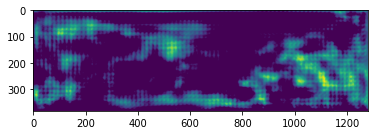

In [6]:
ex.run()